![header](../figures/DC_SSH_QG_mapping-banner.png)

***
**Authors:**  Datlas & IGE <br>
**Copyright:** 2022 Datlas & IGE <br>
**License:** MIT

<div class="alert alert-block alert-success">
    <h1><center>Understand the data</center></h1>
    <h5><center>This notebook aims at documenting how to access & manipulate the input datasets of the data challenge.</h5> 
</div> 



The notebook is structured as follow: 

    1) Download the data
    2) ...
    3)  

In [1]:
import xarray as xr 
import os 
import numpy as np
import sys
sys.path.append('..')
sys.path.remove('/Users/sammymetref/Documents/DataChallenges/DC_IW_crossoverCal/2022a_mapping_HFdynamic')
from src.mod_plot import *

<div class="alert alert-info" role="alert">

<h2> Download the data </h2>

</div>

### Retrieve  and load the reference simulation ...

In [ ]:

!wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/dc2022b_q/qg_sim.nc ../data 
#!tar -xvf dc_obs.tar.gz --directory ../
#!rm -f dc_obs.tar.gz

In [ ]:
ds_ref = xr.open_dataset('../data/qg_sim.nc')
ds_ref

### Load SWOT nadir pseudo obs.

In [ ]:
ds_swot_nadir = xr.open_dataset('../dc_obs/2020a_SSH_mapping_NATL60_nadir_swot.nc')
ds_swot_nadir

### Load SWOT karin pseudo obs.

In [ ]:
ds_swot_karin = xr.open_dataset('../dc_obs/2020a_SSH_mapping_NATL60_karin_swot.nc')
ds_swot_karin

In [ ]:
# Get nature run (it may take several minutes depending on your connection!!!!)
!wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/dc_data1/dc_ref.tar.gz

In [ ]:
!tar -xvf dc_ref.tar.gz --directory ../

In [ ]:
!rm -f dc_ref.tar.gz

In [ ]:
dc_ref = xr.open_mfdataset('../dc_ref/*.nc', combine='nested', concat_dim='time')
dc_ref

### Example of figures

In [ ]:
list_of_dataset = [ds_j1, ds_g2, ds_en, ds_tpn]
central_date = numpy.datetime64('2012-10-05')
delta_t = numpy.timedelta64(5, 'D')

In [ ]:
plot_demo_obs(list_of_dataset, dc_ref, central_date, delta_t)

In [ ]:
list_of_dataset = [ds_swot_karin]
central_date = numpy.datetime64('2012-10-05')
delta_t = numpy.timedelta64(5, 'D')

In [ ]:
plot_demo_obs(list_of_dataset, dc_ref, central_date, delta_t)

### Example of "interactive" figures

In [ ]:
list_of_dataset = [ds_j1, ds_g2, ds_en, ds_tpn]
central_date = numpy.datetime64('2012-10-05')
delta_t = numpy.timedelta64(5, 'D')
hvplot_demo_obs_nadir(list_of_dataset, dc_ref, central_date, delta_t)

In [ ]:
list_of_dataset = ds_swot_karin
central_date = numpy.datetime64('2012-10-05')
delta_t = numpy.timedelta64(5, 'D')
hvplot_demo_obs_karin(list_of_dataset, dc_ref, central_date, delta_t)

<div class="alert alert-info" role="alert">

<h2> Switch variables </h2>

</div>

### Downloading an SSH field

In [2]:
# Example on the first day of the evaluation period
path2data = '../data/dc_qg_eval/'
files = sorted(os.listdir(path2data))
ds0 = xr.open_dataset(path2data+files[0])

ssh = np.array(ds0.ssh[0,:,:])
lon = np.array(ds0.nav_lon) 
lat = np.array(ds0.nav_lat)

### Computing relative vorticity and velocity magnitude from ssh

In [49]:
from src.mod_switchvar import *

# Computing relative vorticity from ssh, lon and lat
rv = ssh2rv(ssh, lon=lon, lat=lat)

# Computing velocity magnitude from ssh, lon and lat
u,v,uv = ssh2uv2(ssh, lon=lon, lat=lat)

### Plotting SSH, relative vorticity and velocity magnitude

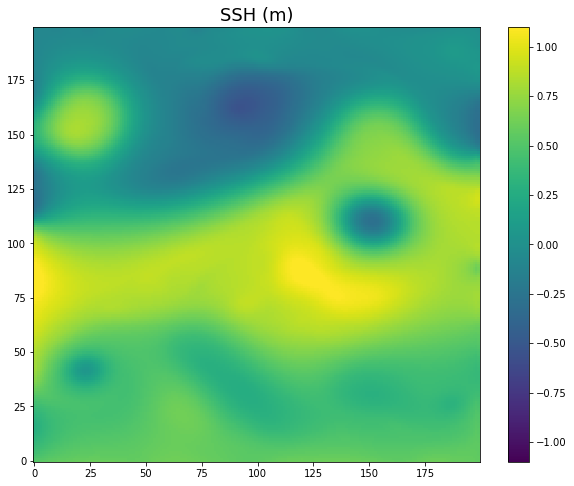

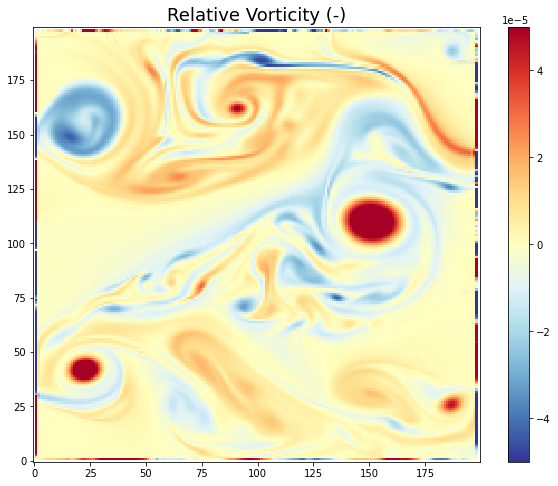

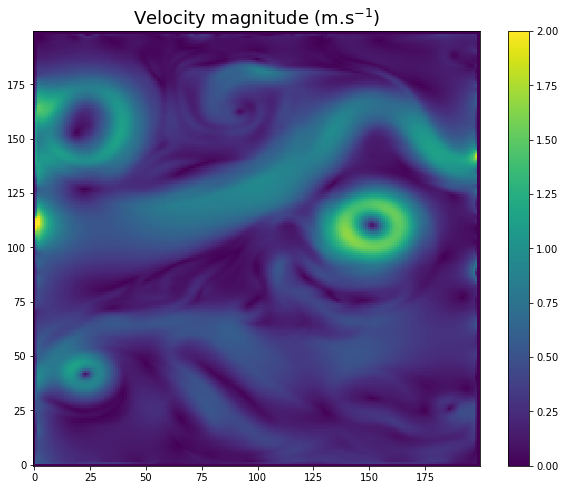

In [115]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8)) 
plt.title('SSH (m)',fontsize=18)
plt.pcolormesh(ds0.lon,ds0.lat,ssh,vmin=-1.1,vmax=1.1,shading='auto')
plt.colorbar()

fig = plt.figure(figsize=(10,8)) 
plt.title('Relative Vorticity (-)',fontsize=18)
plt.pcolormesh(ds0.lon,ds0.lat,rv,vmin=-0.00005,vmax=0.00005,cmap='RdYlBu_r',shading='auto')
plt.colorbar()

fig = plt.figure(figsize=(10,8)) 
plt.title('Velocity magnitude (m.s$^{-1}$)',fontsize=18)
plt.pcolormesh(ds0.lon,ds0.lat,uv,vmin=0,vmax=2,shading='auto')
plt.colorbar()
 
 
plt.show()

In [36]:
lon2,lat2 = np.meshgrid(lon,lat)

In [94]:
deg2m=110000.
fc = 2*2*np.pi/86164*np.sin(lat2*np.pi/180)[1:-1,1:-1]

In [106]:
dy = np.diff(lon2,axis=1)[1:-1,1:]*deg2m*np.cos(lat2[1:-1,1:-1]*np.pi/180.)

In [107]:
dx = np.diff(lat2,axis=0)[1:,1:-1]*deg2m

In [109]:
u0 = xr.DataArray(u[1:-1,1:-1], 
coords={'y': range(np.shape(u[1:-1,1:-1])[0]),'x': range(np.shape(u[1:-1,1:-1])[1])}, 
dims=["y", "x"])

In [110]:
v0 = xr.DataArray(v[1:-1,1:-1], 
coords={'y': range(np.shape(v[1:-1,0:-2])[0]),'x': range(np.shape(v[1:-1,1:-1])[1])}, 
dims=["y", "x"])

In [34]:

def strain(u,v,e1u,e1v,e2u,e2v,ff):
    '''
    This routine computes the relative vorticity from 2D fields of horizontal velocities and the spatial Coriolis parameter.
    '''
    #Computation of dy(u)
    fe2u=1/e2u
    fse2u=fe2u.squeeze()
    dyu=(u.shift(y=-1) - u)*fse2u
    #Computation of dx(v)
    fe1v=1/e1v
    fse1v=fe1v.squeeze()
    dxv=(v.shift(x=-1) - v)*fse1v
    #Computation of dy(v)
    fe2v=1/e2v
    fse2v=fe2v.squeeze()
    dyv=(v.shift(y=-1) - v)*fse2v
    #Computation of dx(u)
    fe1u=1/e1u
    fse1u=fe1u.squeeze()
    dxu=(u.shift(x=-1) - u)*fse1u
    #Projection on the grid T
    dxvt=0.5*(dxv.shift(y=-1)+dxv)
    dyut=0.5*(dyu.shift(x=-1)+dyu)
    dxut=0.5*(dxu.shift(x=-1)+dxu)
    dyvt=0.5*(dyv.shift(y=-1)+dyv)
    #Computation of the strain divided by f
    fff=1/ff
    strain=np.sqrt( (dyut+dxvt)*(dyut+dxvt) + (dxut-dyvt)*(dxut-dyvt) ) *fff
    return strain

In [47]:
def ssh2uv2(Ht,lon,lat):
    dlon = lon[1]-lon[0]
    dlat = lat[1]-lat[0]
    
    if len(lon.shape)==2:
        lon2 = lon
        lat2 = lat
    else:
        lon2,lat2 = np.meshgrid(lon,lat)
    deg2m=110000.
    fc = 2*2*np.pi/86164*np.sin(lat2*np.pi/180)
    Ugt = 0*Ht
    Vgt = 0*Ht

    for t in range(Ht.shape[0]): 
        Vgt[1:-1,1:-1] = 9.81/fc[1:-1,1:-1]*(Ht[1:-1,2:]-Ht[1:-1,:-2])/(2*np.diff(lon2,axis=1)[1:-1,1:]*deg2m*np.cos(lat2[1:-1,1:-1]*np.pi/180.))
        Ugt[1:-1,1:-1] = -9.81/fc[1:-1,1:-1]*(Ht[2:,1:-1]-Ht[:-2,1:-1])/(2*np.diff(lat2,axis=0)[1:,1:-1]*deg2m)

    return Ugt,Vgt,np.sqrt(Ugt**2+Vgt**2)

In [88]:
def curl(u,v,e1v,e2u,ff):
    '''
    This routine computes the relative vorticity from 2D fields of horizontal velocities and the spatial Coriolis parameter.
    '''
    #Computation of dy(u)
    fe2u=1/e2u
    fse2u=fe2u.squeeze()
    dyu=(u.shift(y=-1) - u)*fse2u
    #Computation of dx(v)
    fe1v=1/e1v
    fse1v=fe1v.squeeze()
    dxv=(v.shift(x=-1) - v)*fse1v
    #Projection on the grid T
    dxvt=0.5*(dxv.shift(y=-1)+dxv)
    dyut=0.5*(dyu.shift(x=-1)+dyu)
    #Computation of the vorticity divided by f
    fff=1/ff
    curl=(dxvt-dyut)*fff
    return curl

In [111]:
strain0 = strain(u0,v0,dx,dx,dy,dy,fc)

In [112]:
curl0 = curl(u0,v0,dx,dy,fc)

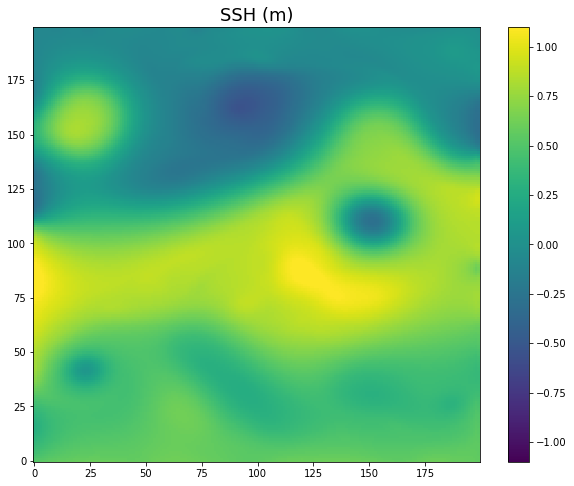

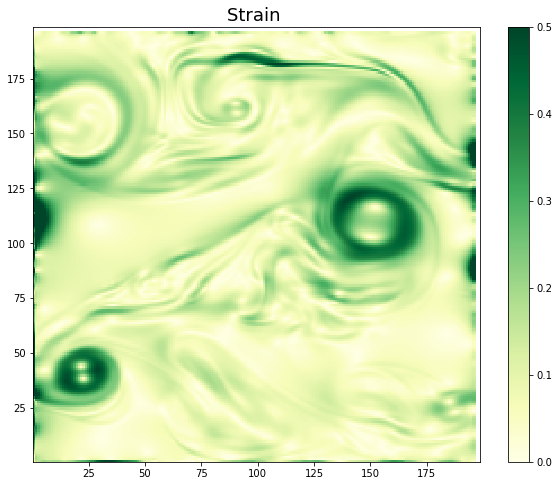

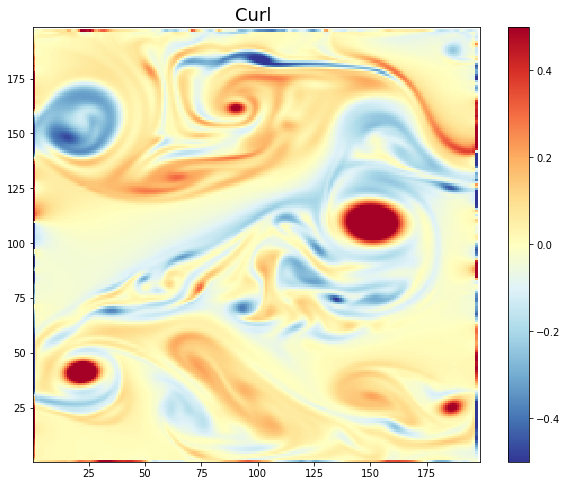

In [114]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8)) 
plt.title('SSH (m)',fontsize=18)
plt.pcolormesh(ds0.lon,ds0.lat,ssh,vmin=-1.1,vmax=1.1,shading='auto')
plt.colorbar()

fig = plt.figure(figsize=(10,8)) 
plt.title('Strain ',fontsize=18)
plt.pcolormesh(ds0.lon[1:-1],ds0.lat[1:-1],strain0,vmin=0,vmax=0.5,cmap='YlGn',shading='auto')
plt.colorbar()

fig = plt.figure(figsize=(10,8)) 
plt.title('Curl ',fontsize=18)
plt.pcolormesh(ds0.lon[1:-1],ds0.lat[1:-1],curl0,vmin=-0.5,vmax=0.5,cmap='RdYlBu_r',shading='auto')
plt.colorbar()


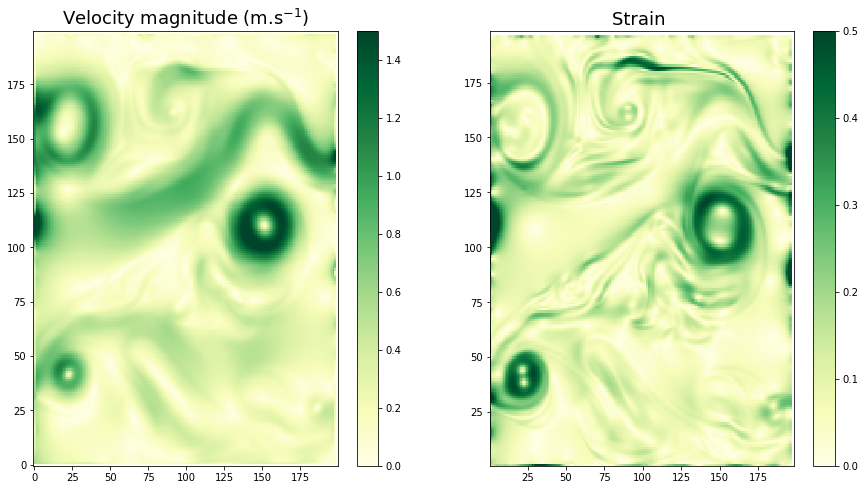

In [120]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,8)) 
plt.subplot(121)
plt.title('Velocity magnitude (m.s$^{-1}$)',fontsize=18)
plt.pcolormesh(ds0.lon,ds0.lat,uv,vmin=0,vmax=1.5,cmap='YlGn',shading='auto')
plt.colorbar()
 
plt.subplot(122)
plt.title('Strain ',fontsize=18)
plt.pcolormesh(ds0.lon[1:-1],ds0.lat[1:-1],strain0,vmin=0,vmax=0.5,cmap='YlGn',shading='auto')
plt.colorbar()

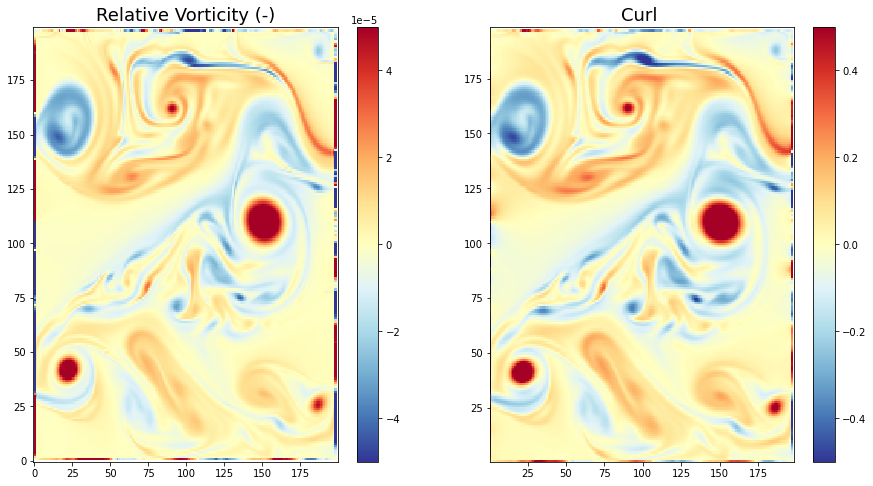

In [126]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,8)) 
plt.subplot(121)
plt.title('Relative Vorticity (-)',fontsize=18)
plt.pcolormesh(ds0.lon,ds0.lat,rv,vmin=-0.00005,vmax=0.00005,cmap='RdYlBu_r',shading='auto')
plt.colorbar()
 
plt.subplot(122)
plt.title('Curl ',fontsize=18)
plt.pcolormesh(ds0.lon[1:-1],ds0.lat[1:-1],curl0,vmin=-0.5,vmax=0.5,cmap='RdYlBu_r',shading='auto')
plt.colorbar()

In [122]:
np.shape(fc)

(198, 198)